<a href="https://colab.research.google.com/github/bobereek/mipt_dl/blob/main/hw_7_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

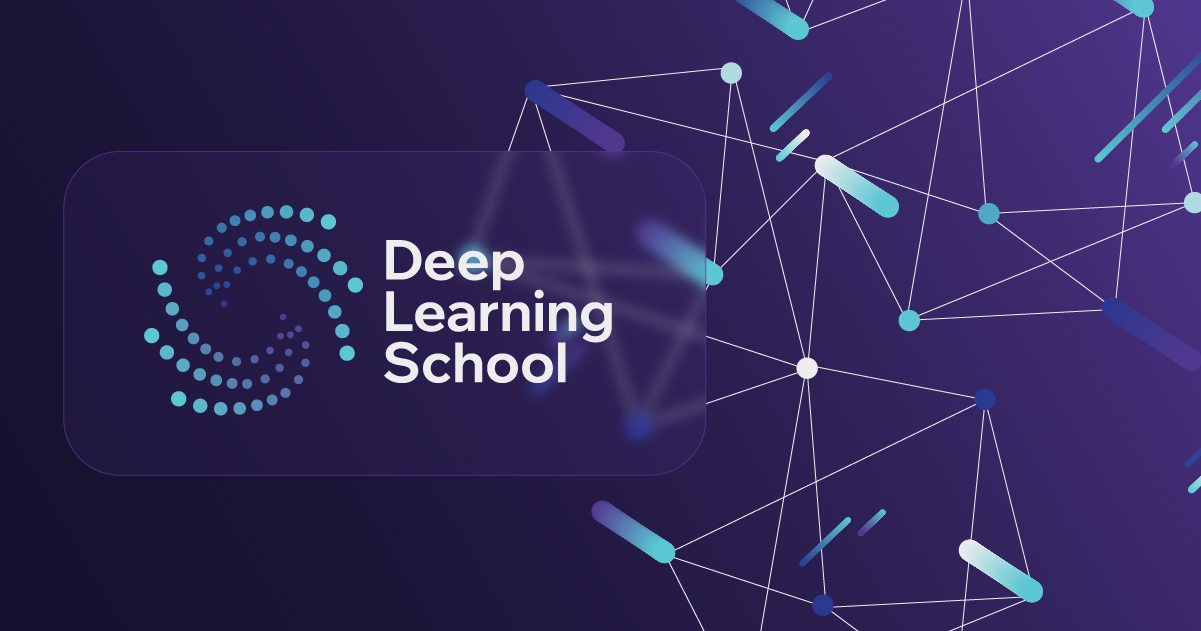

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Детекция объектов</b></h3>

В этом домашнем задании мы продолжим работу над детектором из семинара, поэтому при необходимости можете заимствовать оттуда любой код.

Домашнее задание можно разделить на следующие части:

* Переделываем модель [5]
  * backbone[1],
  * Neck [3],
  * Head [1]
* Label assignment [2]:
  * TAL [2]
* Лоссы [1]:
  * CIoU loss [1]
* Кто больше? [5]
  * 0.15 mAP [1]
  * 0.3 mAP  [2]
  * 0.6 mAP [5]

**Максимальный балл:** 10 баллов. (+3 балла бонус).

In [1]:
# !pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
import torch
import timm
import torch.nn as nn
import numpy as np
import pandas as pd
import albumentations as A

from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
from albumentations.pytorch.transforms import ToTensorV2

import math
from functools import partial
from collections import Counter, defaultdict

import io
import cv2
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
from torchvision.ops import nms, box_iou
from torchvision.models.detection.anchor_utils import AnchorGenerator

from torchmetrics.detection import MeanAveragePrecision
from torchvision.ops import box_convert

### Загрузка данных

Мы продолжаем работу с датасетом из семинара - Halo infinite ([сслыка](https://universe.roboflow.com/graham-doerksen/halo-infinite-angel-aim)). Загрузка данных и создание датасета полностью скопированы из семинара.

Сначала загружаем данные

In [3]:
splits = {'train': 'data/train-00000-of-00001-0d6632d599c29801.parquet',
          'validation': 'data/validation-00000-of-00001-c6b77a557eeedd52.parquet',
          'test': 'data/test-00000-of-00001-866d29d8989ea915.parquet'}
df_train = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["train"])
df_val = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["validation"])
df_test = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["test"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Создаем датасет для предобработки данных

In [40]:
class HaloDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        df_objects = pd.json_normalize(dataframe['objects'])[["bbox", "category"]]
        df_images = pd.json_normalize(dataframe['image'])[["bytes"]]
        self.data = dataframe[["image_id"]].join(df_objects).join(df_images)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """Загружаем данные и разметку для объекта с индексом `idx`.

        labels: List[int] Набор классов для каждого ббокса,
        boxes: List[List[int]] Набор ббоксов в формате (x_min, y_min, w, h).
        """
        row = self.data.iloc[idx]
        image = Image.open(io.BytesIO(row["bytes"]))
        image = np.array(image)

        target = {}
        target["image_id"] = row["image_id"]

        labels = [row["category"]] if isinstance(row["category"], int) else row['category']
        labels = [label - 1 for label in labels]
        boxes = row['bbox'].tolist()

        if self.transform is not None:
            transformed = self.transform(image=image, bboxes=boxes, labels=labels)
            image, boxes, labels = transformed["image"], transformed["bboxes"], transformed["labels"]
        else:
            image = transforms.ToTensor()(image)

        boxes_xyxy = []
        final_valid_labels = []
        if boxes:
            for i, box_coco in enumerate(boxes):
                 if len(box_coco) == 4:
                     x_min, y_min, w, h = box_coco
                     if w > 0 and h > 0:
                         boxes_xyxy.append([x_min, y_min, x_min + w, y_min + h])
                         if i < len(labels):
                             final_valid_labels.append(labels[i])

        if boxes_xyxy:
            target['boxes'] = torch.tensor(boxes_xyxy, dtype=torch.float32)
            target['labels'] = torch.tensor(final_valid_labels, dtype=torch.int64)
        else:
            target['boxes'] = torch.empty((0, 4), dtype=torch.float32)
            target['labels'] = torch.empty((0,), dtype=torch.int64)

        if not isinstance(image, torch.Tensor):
             image = transforms.ToTensor()(image)
        return image, target


# Исходный collate_fn
def collate_fn(batch):
    images, targets = tuple(zip(*batch))
    images = torch.stack(images)
    return images, list(targets)

Тут можно написать любые аугментации

In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
IMAGE_SIZE = 640 # Используем ту же переменную

train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format='coco', label_fields=['labels'], min_visibility=0.1)
)

test_transform = A.Compose(
    [
        A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
     bbox_params=A.BboxParams(format='coco', label_fields=['labels'])
)

Не забываем инициализировать наш датасет

In [91]:
class_to_color = {
    1: (89, 161, 197),
    2: (204, 79, 135),
    3: (125, 216, 93),
    4: (175, 203, 33),
}

class_to_name = {
    1 : "enemy",
    2 : "enemy-head",
    3 : "friendly",
    4 : "friendly-head"
}

train_dataset = HaloDataset(df_train, transform=train_transform)
test_dataset = HaloDataset(df_test, transform=test_transform)
val_dataset = HaloDataset(df_val, transform=test_transform)

In [42]:
val_dataset.data.category

0     [2, 1]
1     [2, 1]
2     [2, 1]
3     [2, 1]
4     [2, 1]
       ...  
66    [2, 1]
67    [2, 1]
68       [1]
69    [2, 1]
70    [4, 3]
Name: category, Length: 71, dtype: object

## Переделываем модель [5 баллов]

В семинаре мы реализовали самый базовый детектор, а сейчас настало время его улучшать.

### Backbone [1 балл]

В лекции мы заморозили все слои у модели. Вам нужно написать бекбоун с возможностью разморозки __k__ последних слоев или блоков (на ваш выбор).

In [7]:
import timm

In [8]:
class Backbone(nn.Module):
    def __init__(self, model_name="efficientnet_b0", unfreeze_last=3, out_indices=(-1, -2, -3)):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=True, features_only=True, out_indices=out_indices)
        for param in self.backbone.parameters():
            param.requires_grad = False

        all_params = list(self.backbone.parameters())
        parameters_to_unfreeze = all_params[-unfreeze_last:]
        unfrozen_param_indices = list(range(len(all_params) - len(parameters_to_unfreeze), len(all_params)))

        if unfreeze_last > 0:
            all_params = list(self.backbone.parameters())
            num_to_unfreeze = min(unfreeze_last, len(all_params))
            for param in all_params[-num_to_unfreeze:]:
                param.requires_grad = True

    def forward(self, x):
        return self.backbone(x)

### NECK [3 балла]

Вам предлагается на выбор написать одну из двух шей:

#### Feature Pyramid Network [2 балла]

Знакомая из лекции архитектура шеи:

<center><img src="https://user-images.githubusercontent.com/57972646/69858594-b14a6c00-12d5-11ea-8c3e-3c17063110d3.png"/></center>


* [Feature Pyramid Networks for Object Detection](https://arxiv.org/abs/1612.03144)

Она состоит из top-down пути, в котором происходит 2 вещи:
1. Увеличивается пространственная размерность фичей,
2. С помощью скипконнекшеннов, добавляются фичи из backbone модели.

Для увеличения пространственной размерности используется __nearest neighbor upsampling__, а фичи из шеи и бекбоуна суммируются.

#### Path Aggregation Network [3 балла]

Другая архитектура немного сложнее. Она содержит не только top-down путь, но ещё bottom-up путь:

<center><img src="https://i.ibb.co/k68BWBGv/path-aggregation-network.png" width="500"/></center>

* [Path Aggregation Network for Instance Segmentation](https://arxiv.org/abs/1803.01534)

Подробное описание архитектуры можно найти в секции 3 (Framework). Реализовывать adaptive feature pooling не нужно.


__TIPS__:
* Можете использовать базовые классы из лекции,
* Воспользуйтесь AnchorGenerator-ом, чтобы создавать якоря сразу для нескольких выходов,
* Не забудьте использовать nn.ModuleList, если захотите сделать динамическое количество голов у модели,
* Также, можно добавить доп конволюцию (3х3 с паддингом) у каждого выхода шеи.

In [9]:
class ConvBNAct(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=None, groups=1):
        super().__init__()
        if padding is None:
            padding = (kernel_size - 1) // 2 * 1 # Dilation=1

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation_layer = nn.SiLU()

    def forward(self, x):
        return self.activation_layer(self.bn(self.conv(x)))

# --- CSP-подобный блок для шеи ---
class CSPBlockNeck(nn.Module):
    def __init__(self, in_channels, out_channels, num_bottleneck_layers=1, expansion=0.5):
        super().__init__()
        hidden_channels = int(out_channels * expansion)
        self.conv1 = ConvBNAct(in_channels, hidden_channels, kernel_size=1)
        self.conv2 = ConvBNAct(in_channels, hidden_channels, kernel_size=1)
        self.bottlenecks = nn.Sequential(
            *(ConvBNAct(hidden_channels, hidden_channels, kernel_size=3) for _ in range(num_bottleneck_layers))
        )
        self.conv_final = ConvBNAct(2 * hidden_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.bottlenecks(x1)
        x2 = self.conv2(x)
        out = self.conv_final(torch.cat((x1, x2), dim=1))
        return out

class PANNeck(nn.Module):
    def __init__(self, backbone_output_channels, neck_output_channels=256, num_csp_blocks=1):
        super().__init__()

        ch_c3, ch_c4, ch_c5 = backbone_output_channels[-3:] # Берем последние три

        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        # Top-down pathway
        self.conv_p5 = ConvBNAct(ch_c5, neck_output_channels, kernel_size=1)
        self.csp_p4 = CSPBlockNeck(ch_c4 + neck_output_channels, neck_output_channels, num_csp_blocks)
        self.csp_p3 = CSPBlockNeck(ch_c3 + neck_output_channels, neck_output_channels, num_csp_blocks) # N3

        # Bottom-up pathway
        self.downsample_n4 = ConvBNAct(neck_output_channels, neck_output_channels, kernel_size=3, stride=2)
        self.csp_n4 = CSPBlockNeck(neck_output_channels * 2, neck_output_channels, num_csp_blocks) # N4
        self.downsample_n5 = ConvBNAct(neck_output_channels, neck_output_channels, kernel_size=3, stride=2)
        self.csp_n5 = CSPBlockNeck(neck_output_channels * 2, neck_output_channels, num_csp_blocks) # N5


    def forward(self, backbone_features):
        feat_c3, feat_c4, feat_c5 = backbone_features[-3:]

        # Top-down
        p5_inter = self.conv_p5(feat_c5)
        p5_up = self.upsample(p5_inter)
        p4_inter = self.csp_p4(torch.cat([feat_c4, p5_up], 1))
        p4_up = self.upsample(p4_inter)
        n3_out = self.csp_p3(torch.cat([feat_c3, p4_up], 1))

        # Bottom-up
        n3_down = self.downsample_n4(n3_out)
        n4_out = self.csp_n4(torch.cat([n3_down, p4_inter], 1))
        n4_down = self.downsample_n5(n4_out)
        n5_out = self.csp_n5(torch.cat([n4_down, p5_inter], 1))

        return (n3_out, n4_out, n5_out)

### Head [1 балл]

В качестве шеи можно выбрать __один из двух__ вариантов:

#### 1. Decoupled Head

Реализовать Decoupled Head из [YOLOX](https://arxiv.org/abs/2107.08430).
<center><img src="https://i.ibb.co/BVtBR2R3/Decoupled-head.jpg"/></center>

**TIP**: Возьмите за основу голову из семинара, тк она сильно похожа на Decoupled Head.

Изменять количество параметров у шей на разных уровнях не обязательно.

#### 2. Confidence score free head

Нужно взять за основу голову из семинара и полностью убрать предсказание confidence score. Чтобы модель предсказывала только 2 группы: ббоксы и классы.

Есть следующие способы удаления confidence score:
* Добавление нового класса ФОН. Обычно его обозначают нулевым классом.
* Присваивание ббоксам БЕЗ объекта вектор из нулей в качестве таргета.

Выберете тот, который вам больше нравится и будте внимательны при расчете лосса!

**Важно!** Удаление confidence score повлияет на следующие методы из семинара:
* target_assign
* ComputeLoss
* _filter_predictions

In [10]:
class DecoupledHead(nn.Module):
    def __init__(self, num_classes, num_anchors_per_level, neck_channels=256, head_channels=256):
        super().__init__()
        self.num_anchors = num_anchors_per_level # Сохраняем количество якорей

        self.cls_convs = nn.Sequential(
            ConvBNAct(neck_channels, head_channels, kernel_size=3),
            ConvBNAct(head_channels, head_channels, kernel_size=3)
        )
        self.reg_convs = nn.Sequential(
            ConvBNAct(neck_channels, head_channels, kernel_size=3),
            ConvBNAct(head_channels, head_channels, kernel_size=3)
        )

        # --- Изменяем выходные каналы предсказателей ---
        self.cls_predictor = nn.Conv2d(head_channels, num_anchors_per_level * num_classes, kernel_size=1)
        self.reg_predictor = nn.Conv2d(head_channels, num_anchors_per_level * 4, kernel_size=1) # bbox
        self.obj_predictor = nn.Conv2d(head_channels, num_anchors_per_level * 1, kernel_size=1) # objectness

        self._initialize_biases()

    def _initialize_biases(self, prior_prob=1e-2):
        bias_value = -math.log((1 - prior_prob) / prior_prob) # Используем math.log для скаляра
        nn.init.constant_(self.cls_predictor.bias, bias_value)
        nn.init.constant_(self.obj_predictor.bias, bias_value)

    def forward(self, neck_features):
        cls_outputs, reg_outputs, obj_outputs = [], [], []

        for feature_level in neck_features:
            cls_feat = self.cls_convs(feature_level)
            reg_feat = self.reg_convs(feature_level)

            cls_outputs.append(self.cls_predictor(cls_feat))
            reg_outputs.append(self.reg_predictor(reg_feat))
            obj_outputs.append(self.obj_predictor(reg_feat))

        return cls_outputs, reg_outputs, obj_outputs

Теперь можно снова реализовать класс детектора с учетом всех частей выше!

In [11]:
class Model(nn.Module):
    def __init__(self, backbone_name="efficientnet_b0", num_classes=4,
                 unfreeze_last=3, backbone_out_indices=(-3, -2, -1),
                 neck_output_channels=128,
                 head_channels=128,
                 anchor_sizes=((32,), (64,), (128,)),
                 aspect_ratios=((0.5, 1.0, 2.0),) * 3,
                 pretrained_backbone=True, **kwargs):
        super().__init__()
        self.num_classes = num_classes

        self.backbone = Backbone(
            model_name=backbone_name,
            unfreeze_last=unfreeze_last,
            out_indices=backbone_out_indices
        )
        backbone_output_channels = self.backbone.backbone.feature_info.channels()
        self.strides = self.backbone.backbone.feature_info.reduction()[-len(backbone_out_indices):]

        self.neck = PANNeck(
            backbone_output_channels=backbone_output_channels,
            neck_output_channels=neck_output_channels,
            num_csp_blocks=1
        )

        # --- Вычисляем количество якорей на позицию ---
        # Предполагаем, что anchor_sizes и aspect_ratios одинаковы для всех уровней в этом setup
        # Если они разные, нужно будет передавать список num_anchors в голову
        if isinstance(anchor_sizes[0], (int, float)): # Если только один размер на уровень
            num_anchors_per_level = len(aspect_ratios[0])
        elif isinstance(anchor_sizes[0], (list, tuple)): # Если несколько размеров на уровень
            num_anchors_per_level = len(anchor_sizes[0]) * len(aspect_ratios[0])
        else:
             raise ValueError("anchor_sizes format not recognized")
        self.num_anchors_per_level = num_anchors_per_level

        # --- Передаем num_anchors_per_level в голову ---
        self.head = DecoupledHead(
            num_classes=num_classes,
            num_anchors_per_level=self.num_anchors_per_level, # <--- Добавлено
            neck_channels=neck_output_channels,
            head_channels=head_channels
        )

        self.anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)

    # forward и get_anchors остаются как в предыдущем исправлении
    def forward(self, x):
        B, C, H, W = x.shape
        image_size = (H, W)
        features = self.backbone(x)
        neck_features = self.neck(features)

        strides_for_grid = [[s, s] for s in self.strides]
        grid_sizes = [feature_map.shape[-2:] for feature_map in neck_features]

        anchors_list_xyxy = self.anchor_generator.grid_anchors(grid_sizes, strides_for_grid)
        anchors_list_xyxy = [anchors.to(x.device) for anchors in anchors_list_xyxy]

        head_outputs = self.head(neck_features)

        return head_outputs, anchors_list_xyxy

## Label assignment [2]
В этой секции предлагается заменить функцию `assign_target` на более современный алгоритм который называется Task alignment learning.

Он описан в статье [TOOD](https://arxiv.org/abs/2108.07755) в секции 3.2. Для удобства вот его основные шаги:

1. Посчитать значение метрики для каждого предсказанного ббокса:
    
$$t = s^\alpha * u^\beta$$
    
где,
* $s$ — classification score, или вероятность принадлежности предсказанного ббокса к классу реального ббокса (**GT**);
* $u$ — IoU между предсказанным и реальным ббоксами;
* $\alpha,\ \beta$ — нормализационные константы, обычно $\alpha = 6.0, \ \beta = 1.0$.
    
2. Отфильтровать предсказания на основе **GT**.

    Для якорных детекторов, обычно, выбираются только те предсказания, центры якорей которых находятся внутри GT.
4. Для каждого **GT** выбрать несколько (обычно 5 или 13) самых подходящих предсказаний.
5. Если предсказание рассматривается в качестве подходящего для нескольких **GT** — выбрать **GT** с наибольшим пересечением по IoU.


**BAЖНО**: если будете использовать Runner из лекции, не забудьте поменять параметры  в `self.assign_target_method` в методе `_run_train_epoch`.

In [12]:
def tal_assigner(pred_cls_scores, pred_bboxes_xyxy, anchor_points_xy, gt_bboxes_xyxy, gt_labels, topk=13, alpha=6.0, beta=1.0):
    num_anchors = pred_bboxes_xyxy.shape[0]
    num_gt = gt_bboxes_xyxy.shape[0]
    device = pred_bboxes_xyxy.device
    num_classes = pred_cls_scores.shape[1]

    assigned_gt_inds = torch.full((num_anchors,), -1, dtype=torch.long, device=device)
    assigned_labels = torch.full((num_anchors,), num_classes, dtype=torch.long, device=device)
    assigned_bboxes = torch.zeros((num_anchors, 4), dtype=torch.float32, device=device)
    assigned_scores = torch.zeros((num_anchors, num_classes), dtype=torch.float32, device=device)

    if num_gt == 0:
        fg_mask = torch.zeros(num_anchors, dtype=torch.bool, device=device)
        return assigned_gt_inds, assigned_labels, assigned_bboxes, assigned_scores, fg_mask

    # --- Шаг 1: Считаем IoU ---
    # Матрица IoU между предсказанными боксами и GT боксами [Num_Anchors, Num_GT]
    iou_matrix = box_iou(pred_bboxes_xyxy, gt_bboxes_xyxy)

    # --- Шаг 2: Считаем метрику выравнивания (Alignment Metric) ---
    # Получаем вероятности классов (применяем сигмоиду к логитам)
    pred_cls_probs = pred_cls_scores.sigmoid() # [Num_Anchors, Num_Classes]
    # Берем вероятности предсказанного класса, соответствующего *истинному* классу GT
    # gt_labels: [Num_GT] -> нужны индексы для gather
    gt_labels_expanded = gt_labels.reshape(1, num_gt).expand(num_anchors, num_gt) # [N, M]
    # Собираем нужные скоры: cls_probs[якорь_i, gt_класс_j]
    cls_scores_for_gt = torch.gather(pred_cls_probs, 1, gt_labels_expanded) # [N, M]

    # Метрика выравнивания t = s^alpha * u^beta
    alignment_metric = (cls_scores_for_gt.pow(alpha)) * (iou_matrix.pow(beta)) # [N, M]

    # --- Шаг 3: Фильтруем кандидатов (центр якоря внутри GT) ---
    # Проверяем, лежит ли центр якоря anchor_points_xy [N, 2] внутри каждого GT бокса [M, 4]
    anchor_cx = anchor_points_xy[:, 0].unsqueeze(1).expand(-1, num_gt) # [N, M]
    anchor_cy = anchor_points_xy[:, 1].unsqueeze(1).expand(-1, num_gt) # [N, M]
    gt_xmin = gt_bboxes_xyxy[:, 0].unsqueeze(0).expand(num_anchors, -1) # [N, M]
    gt_ymin = gt_bboxes_xyxy[:, 1].unsqueeze(0).expand(num_anchors, -1) # [N, M]
    gt_xmax = gt_bboxes_xyxy[:, 2].unsqueeze(0).expand(num_anchors, -1) # [N, M]
    gt_ymax = gt_bboxes_xyxy[:, 3].unsqueeze(0).expand(num_anchors, -1) # [N, M]

    # Маска [N, M]: True, если центр якоря i внутри GT j
    is_in_gt_mask = (anchor_cx >= gt_xmin) & (anchor_cx <= gt_xmax) & \
                    (anchor_cy >= gt_ymin) & (anchor_cy <= gt_ymax)

    # --- Шаг 4 & 5: Выбираем Top K и разрешаем конфликты ---
    # Маскируем метрики для якорей, чьи центры не внутри GT
    # Используем очень маленькое значение, чтобы они не попали в topk
    candidate_metrics = torch.where(is_in_gt_mask, alignment_metric, torch.tensor(-1.0, device=device))

    # Тензор для хранения лучшей метрики для каждого якоря (для разрешения конфликтов)
    max_metric_per_anchor = torch.full((num_anchors,), -1.0, dtype=torch.float32, device=device)

    # Проходим по каждому GT объекту
    for gt_idx in range(num_gt):
        # Метрики кандидатов для текущего GT [Num_Anchors]
        current_gt_metrics = candidate_metrics[:, gt_idx]

        # Находим topk якорей по метрике выравнивания
        num_valid_candidates = (current_gt_metrics > -1).sum() # Считаем только валидных кандидатов
        current_topk = min(topk, num_valid_candidates.item()) # Не берем больше, чем есть валидных

        if current_topk > 0:
            # Получаем значения и индексы topk метрик
            topk_metrics, topk_indices = torch.topk(current_gt_metrics, k=current_topk)

            # --- Разрешение конфликтов ---
            # Проверяем, лучше ли текущее назначение (topk_metrics) для этих якорей (topk_indices),
            # чем их предыдущее лучшее назначение (max_metric_per_anchor[topk_indices])
            is_better_assignment = topk_metrics > max_metric_per_anchor[topk_indices]

            # Обновляем назначения только там, где текущее лучше
            indices_to_update = topk_indices[is_better_assignment]
            assigned_gt_inds[indices_to_update] = gt_idx
            # Обновляем лучшую метрику для этих якорей
            max_metric_per_anchor[indices_to_update] = topk_metrics[is_better_assignment]

    # --- Шаг 6: Генерируем финальные таргеты ---
    # Маска для позитивных якорей (те, которым назначен GT)
    fg_mask = assigned_gt_inds >= 0

    # Назначаем метки классов
    assigned_labels[fg_mask] = gt_labels[assigned_gt_inds[fg_mask]]

    # Назначаем боксы
    assigned_bboxes[fg_mask] = gt_bboxes_xyxy[assigned_gt_inds[fg_mask]]

    # Назначаем таргетные скоры для классификации (используем IoU, как в TOOD)
    # Только для позитивных якорей и только для назначенного класса GT
    if fg_mask.any():
        assigned_iou = iou_matrix[fg_mask, assigned_gt_inds[fg_mask]] # [Num_Pos]
        # Создаем one-hot маску для классов позитивных якорей
        one_hot_labels = F.one_hot(assigned_labels[fg_mask], num_classes=num_classes) # [Num_Pos, Num_Classes]
        # Заполняем assigned_scores: там где one_hot=1, ставим IoU, иначе 0
        assigned_scores[fg_mask] = one_hot_labels * assigned_iou.unsqueeze(-1)

    # Возвращаем назначенные индексы, метки, боксы, скоры и маску позитивных
    return assigned_gt_inds, assigned_labels, assigned_bboxes, assigned_scores, fg_mask

### DIoU [1]

Вместо SmoothL1, который используется в семинаре, реализуем лосс, основанный на пересечении ббоксов. В качестве тренировки давайте напишем Distance Intersection over Union (DIoU).

<center><img src=https://wikidocs.net/images/page/163613/Free_Fig_5.png></center>

Для его реализации разобъем задачу на части:

**1. Реализуем IoU:**

Пусть даны координаты для предсказанного ($B^p$) и истинного ($B^g$) ббоксов в формате XYXY или VOC PASCAL (левый верхний и правый нижний углы):

$B^p=(x^p_1, y^p_1, x^p_2, y^p_2)$, $B^g=(x^g_1, y^g_1, x^g_2, y^g_2)$, тогда алгоритм расчета будет следующий:

    1. Найдем площади обоих ббоксов:
$$ A^p = (x^p_2 - x^p_1) * (y^p_2 - y^p_1) $$
$$ A^g = (x^g_2 - x^g_1) * (y^g_2 - y^g_1) $$

    2. Посчитаем пересечение между ббоксами:

Тут мы предлагаем вам подумать как в общем виде можно расчитать размеры ббокса, который будет являться пересечением $B^p$ и $B^g$, а затем посчитать его площадь:

$$x^I_1 = \qquad \qquad y^I_1 = $$
$$x^I_2 = \qquad \qquad y^I_2 = $$

В общем виде, площать будет записываться следующим образом:

Если $x^I_2 > x^I_1$ & $y^I_2 > y^I_1$, тогда:

$$I = (x^I_2 - x^I_1) * (y^I_2 - y^I_1)$$

Иначе, $I = 0$.

    3. Считаем объединение ббоксов.

Мы можем посчитать эту площадь как сумму площадей двух ббоксов минус площадь пересечения (тк мы считаем её два раз в сумме площадей):

$$U = A^p + A^g - I$$

    4. Вычисляем IoU.

$$IoU = \frac{I}{U}$$

**2. Рассчитаем площадь выпуклой оболочки:**

Для расчета площади, сначала выпишите координаты верхнего левого и правого нижнего углов. Подумайте, чему будут равны эти координаты в общем случае?

$$x^С_1 = \qquad \qquad y^С_1 = $$
$$x^С_2 = \qquad \qquad y^С_2 = $$

Подсказка: Нарисуйте несколько вариантов пересечений предсказания и GT на бумажке, и выпишите координаты для выпуклой оболочки.

$$C = (x^C_2 - x^C_1) * (y^C_2 - y^C_1)$$

**3. Рассчитаем расстояние между цетрами ббоксов:**

Сначала находим координаты центров каждого из ббоксов (если ббоксы в формате YOLO, то и считать ничего не нужно), затем считаем Евклидово расстояние между центрами.

$d = $

Собираем все части вместе и считаем лосс по формуле:

$$ DIoU = 1 - IoU + \frac{d^2}{C^2}$$

Помните, что пар ббоксов может быть много! Возвращайте усредненное значение лосса.

In [13]:
from torchvision.ops import distance_box_iou_loss

In [14]:
def gen_bbox(num_boxes=10):
    min_corner = torch.randint(0, 100, (num_boxes, 2))
    max_corner = torch.randint(50, 150, (num_boxes, 2))

    for i in range(2):
        wrong_order = min_corner[:, i] > max_corner[:, i]
        if wrong_order.any():
            min_corner[wrong_order, i], max_corner[wrong_order, i] = max_corner[wrong_order, i], min_corner[wrong_order, i]
    return torch.cat((min_corner, max_corner), dim=1)

In [15]:
pred_boxes = gen_bbox(num_boxes=100)
true_boxes = gen_bbox(num_boxes=100)

In [16]:
print(f" DIoU: {distance_box_iou_loss(pred_boxes, true_boxes, reduction='mean').item()}")

 DIoU: 1.0183677673339844


In [17]:
def calc_diou(pred_bb, gt_bb):
    pred_area = (pred_bb[2] - pred_bb[0]) * (pred_bb[3] - pred_bb[1])
    gt_area = (gt_bb[2] - gt_bb[0]) * (gt_bb[3] - gt_bb[1])

    inter_coord = [max(pred_bb[0], gt_bb[0]), max(pred_bb[1], gt_bb[1]), min(pred_bb[2], gt_bb[2]), min(pred_bb[3], gt_bb[3])]
    inter_area = max((inter_coord[2] - inter_coord[0]) * (inter_coord[3] - inter_coord[1]), 0)

    union_area = pred_area + gt_area - inter_area + 1e-8
    iou = inter_area / union_area

    outer_coord = [min(pred_bb[0], gt_bb[0]), min(pred_bb[1], gt_bb[1]), max(pred_bb[2], gt_bb[2]), max(pred_bb[3], gt_bb[3])]
    outer_dist = (outer_coord[2] - outer_coord[0]) ** 2 + (outer_coord[3] - outer_coord[1]) ** 2 + 1e-8

    pred_bb_center = [(pred_bb[2] + pred_bb[0]) / 2, (pred_bb[1] + pred_bb[3]) / 2]
    gt_bb_center = [(gt_bb[2] + gt_bb[0]) / 2, (gt_bb[1] + gt_bb[3]) / 2]

    centers_dist = (pred_bb_center[0] - gt_bb_center[0]) ** 2 + (pred_bb_center[1] - gt_bb_center[1]) ** 2

    return 1 - iou + centers_dist / outer_dist


def diou_loss(pred_boxes, gt_boxes):
    sum_diou = 0.0
    for pred_bb, gt_bb in zip(pred_boxes, gt_boxes):
        sum_diou += calc_diou(pred_bb, gt_bb)
    return (sum_diou / len(pred_boxes)).item()

In [18]:
pred_boxes = gen_bbox(num_boxes=1000)
true_boxes = gen_bbox(num_boxes=1000)

# проверим что написанный лосс выдает те же результаты что и лосс из торча.
assert np.isclose(diou_loss(pred_boxes, true_boxes), distance_box_iou_loss(pred_boxes, true_boxes, reduction="mean"), atol=1e-2)

## Кто больше? [5 баллов]

Наконец то мы дошли до самый интересной части. Тут мы раздаем очки за mAP'ы!

Все что вы написали выше вам поможет улучшить качество итогового детектора, настало время узнать насколько сильно :)

За достижения порога по mAP на тестовом наборе вы получаете баллы:
* 0.15 mAP [1]
* 0.3 mAP [2]
* 0.6 mAP [5]


**TIPS**:
1. На семинаре мы специально не унифицировали формат ббоксов между методами, чтобы обратить ваше внимание что за этим нужно следить. Чтобы было проще, сразу унифицируете формат по всему ноутбуку. Советуем использовать формат xyxy, тк IoU и NMS из torch используют именно этот формат. (Не забудьте поменять формат у таргета в `HaloDataset`).
2. Попробуйте перейти к IoU-based лоссу при обучении. То есть обучать не смещения, а сразу предсказывать ббокс.
3. Поэксперементируйте с подходами target assignment'а в процессе обучения. Например, можно на первых итерациях использовать обычный метод, а затем подключить TAL.
4. Добавьте аугментаций!

   Можно взять [albumentations](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/), библиотеку, которую мы использовали всеминаре. Или базовые аугментации из торча [тык](https://pytorch.org/vision/main/transforms.html). Если будете использовать торч, не забудте про ббоксы, transforms из коробки не будет их агументировать.
7. Попробуйте добавлять различные блоки из YOLO архитектур в шею вместо единичных конволюционных слоев. (Например, замените конволюции 3х3 на CSP блоки).
8. Попробуйте заменить NMS на другой метод (WeightedNMS, SoftNMS, etc.). Немного ссылок:
    * Статья про SoftNMS [тык](https://arxiv.org/pdf/1704.04503)
    * Статья про WeightedNMS [тык](https://openaccess.thecvf.com/content_ICCV_2017_workshops/papers/w14/Zhou_CAD_Scale_Invariant_ICCV_2017_paper.pdf)
    * Есть их реализация, правда на нумбе [git](https://github.com/ZFTurbo/Weighted-Boxes-Fusion?tab=readme-ov-file)
10. Не бойтесь эксперементировать и удачи!

Также, напишите развернутые ответы на следующие вопросы:

**Questions:**
1. Какой метод label assignment'a помогает лучше обучаться модели? Почему?
2. Какое из сделаных вами улучшений внесло наибольший вклад в качество модели? Как вы думаете, почему это произошло?
3. Какое из сделанных вами улучшений вообще не изменило метрику? Как вы думаете, почему это произошло?

Ниже определена вспомогательная функция для валидации качества. Можете использовать `Runner.validate`. Важное уточнение, ей нужен метод для фильтрации предсказаний. Можете тоже скопировать его из семинара, если он у вас не менялся.

In [19]:
def safe_logit(x):
    """ Безопасный расчет logit'ов. """
    eps = 1e-6
    x = torch.clamp(x, eps, 1 - eps)
    return torch.log(x / (1 - x))

def get_target_offset(anchor_box, gt_box):
    """ Расчитываем таргет как желаемые смещения от якорей до GT.

    anchor_box: torch.Tensor в формате (x_min, y_min, x_max, y_max),
    gt_box: torch.Tensor в формате (x_min, y_min, x_max, y_max).
    """
    # Конвертируем GT в формат (x_center, y_center), (w, h)
    gt_center = (gt_box[:2] + gt_box[2:]) / 2
    gt_size = gt_box[2:] - gt_box[:2]

    # Конвертируем якоря в формат (x_center, y_center), (w, h)
    anchor_center = (anchor_box[:2] + anchor_box[2:]) / 2
    anchor_size = anchor_box[2:] - anchor_box[:2]

    # Вычисляем значения смещений для положительных ббоксов
    tx = (gt_center[0] - anchor_center[0]) / anchor_size[0]
    ty = (gt_center[1] - anchor_center[1]) / anchor_size[1]
    target_tx = safe_logit(tx)
    target_ty = safe_logit(ty)

    target_tw = torch.log(gt_size[0] / anchor_size[0])
    target_th = torch.log(gt_size[1] / anchor_size[1])
    return torch.tensor([target_tx, target_ty, target_tw, target_th]).to(anchor_box.device)

In [20]:
def assign_target(anchors, gt_boxes, gt_labels, num_classes, pos_th=0.6, neg_th=0.3):
    """ Для каждого GT находим якоря, которые будут участвовать в расчете лосса по следующему алгоритму:
    1. Положительные якоря - якоря у которых IoU с GT >= `pos_th`,
    2. Игнорируемые якоря - `neg_th` <= IoU c GT < `pos_th`,
    3. Отрицательные якоря - IoU c GT < `neg_th`.
    4. Если для GT не нашлось ни одного якоря, назначаем GT якорь с самым большим IoU.

    Параметры
    ---------
    anchors : list[list[float]]
        Набор якорей для выходной фичемапы, размер (NUM_ANCHORS * W * H, 4)
    gt_boxes : list[list[float]]
        Набор истинных ббоксов на изображении, размер (N_GT, 4)
    gt_labels : list[int]
        Набор лейблов для GT, размер (N_GT, )
    num_classes : int
        Количество классов в датасете
    pos_th : float
        Минимальная граница по IoU между якорем и GT после которой якорь считается положительным.
    neg_th : float
        Верхняя граница по IoU между якорем и GT когда якорь считается отрицательным.

    Returns
    -------
    target_offsets: Массив, содержащий истинные смещения для положительных якорей, 0 для всех остальных
    target_objectness: Массив, содержащий тип каждого якоря (1 - положительный, 0 - отрицательный, -1 - игнорируемый)
    target_cls: Массив, содержащий ohe классы для каждого якоря. Для всех, кроме положительных якорей, класс не указан.
    """
    num_anchors = anchors.shape[0]
    target_objectness = torch.zeros(num_anchors, device=anchors.device)
    target_offsets = torch.zeros((num_anchors, 4), device=anchors.device)
    target_cls = torch.zeros((num_anchors, num_classes), device=anchors.device)
    # Если на изображении нет объектов, возвращаем пустые списки
    if gt_boxes.numel() == 0:
        return target_offsets, target_objectness, target_cls
    # box_iou работает с форматом ббоксов (x_min, y_min, x_max, y_max)
    # Якоря находятся в нужном формате, а GT - нет, тк имеет формат (x_min, y_min, w, h)
    # Переведем GT боксы в нужный формат
    gt_xyxy = gt_boxes.clone()
    gt_xyxy[:, 2:] = gt_xyxy[:, :2] + gt_xyxy[:, 2:]
    # Считаем iou между всеми якорями и всеми GT
    ious = box_iou(anchors, gt_xyxy) # [num_anchors, num_gt]
    # Находим самый оптимальный GT для каждого якоря
    best_iou, best_gt_idx = ious.max(dim=1)
    # Отмечаем якоря, которые будут пропущены при расчете лосса
    ignore_mask = (best_iou >= neg_th) & (best_iou < pos_th)
    target_objectness[ignore_mask] = -1

    # Отмечаем якоря, для которых будет считаться локализационный лосс
    pos_mask = best_iou >= pos_th
    pos_indices = pos_mask.nonzero(as_tuple=True)[0]
    for pos in pos_indices:
        gt_idx = best_gt_idx[pos]
        gt_box = gt_xyxy[gt_idx]
        anchor_box = anchors[pos]

        target_offsets[pos] = get_target_offset(anchor_box, gt_box)
        target_objectness[pos] = 1
        target_cls[pos, gt_labels[gt_idx]] = 1

    # Присваиваем предсказание с самым большим IoU для GT
    # у которых не нашлось ни оного предсказания
    for gt_idx in range(gt_xyxy.shape[0]):
        if not((target_objectness == 1) & (best_gt_idx == gt_idx)).any():
            best_anchor_idx = torch.argmax(ious[:, gt_idx])
            target_offsets[best_anchor_idx] = get_target_offset(anchors[best_anchor_idx], gt_xyxy[gt_idx])
            target_objectness[best_anchor_idx] = 1
            target_cls[best_anchor_idx, gt_labels[gt_idx]] = 1
    return target_offsets, target_objectness, target_cls

In [74]:
def _filter_predictions(pred_bboxes_batch, pred_obj_scores_batch, pred_cls_scores_batch,
                           num_classes, score_threshold=0.01, # Порог Objectness
                           cls_score_threshold=0.05, # <--- НОВЫЙ ПОРОГ ДЛЯ КЛАССА
                           nms_threshold=0.5,
                           max_boxes_per_cls=100,
                           max_total_boxes=100, # <--- ОПЦИОНАЛЬНО: Ограничение на общее число боксов
                           return_type="list"):
    """
    Фильтрует предсказания:
    1. По objectness score.
    2. Применяет NMS по классам (используя class score).
    3. Фильтрует по class score ПОСЛЕ NMS. # <--- ДОБАВЛЕНО
    4. Ограничивает общее количество боксов на изображение. # <--- ДОБАВЛЕНО
    """
    batch_size = len(pred_bboxes_batch)
    final_predictions = []

    for i in range(batch_size):
        pred_bboxes_xyxy_i = pred_bboxes_batch[i]
        pred_obj_scores_i = pred_obj_scores_batch[i].squeeze(-1)
        pred_cls_scores_i = pred_cls_scores_batch[i]
        current_device = pred_bboxes_xyxy_i.device

        # --- Шаг 1: Фильтрация по objectness score ---
        obj_keep_mask = pred_obj_scores_i > score_threshold
        if not obj_keep_mask.any():
             # Обработка случая, когда ничего не прошло порог objectness
             preds_img = {'boxes': torch.empty((0, 4), dtype=torch.float32, device=current_device),
                          'labels': torch.empty((0,), dtype=torch.long, device=current_device),
                          'scores': torch.empty((0,), dtype=torch.float32, device=current_device)}
             if return_type == "list":
                 preds_img = {k: v.cpu().tolist() for k, v in preds_img.items()}
             final_predictions.append(preds_img)
             continue

        bboxes_after_obj = pred_bboxes_xyxy_i[obj_keep_mask]
        cls_scores_after_obj = pred_cls_scores_i[obj_keep_mask]

        all_boxes_nms = []
        all_labels_nms = []
        all_scores_nms = [] # Скоры классов после NMS

        # --- Шаг 2: NMS по классам ---
        for cls_idx in range(num_classes):
            cls_scores_current = cls_scores_after_obj[:, cls_idx]
            # Можно добавить фильтрацию по cls_score *здесь*, чтобы уменьшить нагрузку на NMS,
            # но стандартно это делают после NMS для mAP.
            # pre_nms_mask = cls_scores_current > cls_score_threshold # Опционально
            # boxes_to_nms = bboxes_after_obj[pre_nms_mask]
            # scores_to_nms = cls_scores_current[pre_nms_mask]
            # if len(boxes_to_nms) == 0: continue
            # keep_indices_nms = nms(boxes_to_nms, scores_to_nms, nms_threshold)
            # ... и т.д.

            # Стандартный вариант: NMS по всем прошедшим objectness
            keep_indices_nms = nms(bboxes_after_obj, cls_scores_current, nms_threshold)

            if len(keep_indices_nms) > 0:
                bboxes_kept_nms = bboxes_after_obj[keep_indices_nms]
                scores_kept_nms = cls_scores_current[keep_indices_nms] # Скоры классов
                labels_kept_nms = torch.full_like(scores_kept_nms, cls_idx, dtype=torch.long)

                # Ограничение max_boxes_per_cls
                if len(bboxes_kept_nms) > max_boxes_per_cls:
                    top_scores_idx = torch.argsort(scores_kept_nms, descending=True)[:max_boxes_per_cls]
                    bboxes_kept_nms = bboxes_kept_nms[top_scores_idx]
                    scores_kept_nms = scores_kept_nms[top_scores_idx]
                    labels_kept_nms = labels_kept_nms[top_scores_idx]

                all_boxes_nms.append(bboxes_kept_nms)
                all_labels_nms.append(labels_kept_nms)
                all_scores_nms.append(scores_kept_nms)

        # --- Шаг 3: Фильтрация по class score ПОСЛЕ NMS ---
        if len(all_boxes_nms) > 0:
            boxes_after_nms = torch.cat(all_boxes_nms, dim=0)
            labels_after_nms = torch.cat(all_labels_nms, dim=0)
            scores_after_nms = torch.cat(all_scores_nms, dim=0) # Скоры классов

            # Применяем порог class score
            cls_keep_mask = scores_after_nms > cls_score_threshold # <--- ФИЛЬТРУЕМ ЗДЕСЬ
            boxes_after_cls_thresh = boxes_after_nms[cls_keep_mask]
            labels_after_cls_thresh = labels_after_nms[cls_keep_mask]
            scores_after_cls_thresh = scores_after_nms[cls_keep_mask] # Эти скоры пойдут в метрику

            # --- Шаг 4: Ограничение общего числа боксов ---
            if len(boxes_after_cls_thresh) > max_total_boxes:
                # Сортируем по скору класса и берем топ
                top_scores_idx = torch.argsort(scores_after_cls_thresh, descending=True)[:max_total_boxes]
                boxes_final = boxes_after_cls_thresh[top_scores_idx]
                labels_final = labels_after_cls_thresh[top_scores_idx]
                scores_final = scores_after_cls_thresh[top_scores_idx] # Финальные скоры для метрики
            else:
                boxes_final = boxes_after_cls_thresh
                labels_final = labels_after_cls_thresh
                scores_final = scores_after_cls_thresh

        else: # Если ничего не осталось после NMS
            boxes_final = torch.empty((0, 4), dtype=torch.float32, device=current_device)
            labels_final = torch.empty((0,), dtype=torch.long, device=current_device)
            scores_final = torch.empty((0,), dtype=torch.float32, device=current_device)

        preds_img = {'boxes': boxes_final, 'labels': labels_final, 'scores': scores_final} # scores - это скоры классов

        if return_type == "list":
             preds_img = {k: v.cpu().tolist() for k, v in preds_img.items()}
        elif return_type != "torch":
             raise ValueError(f"Invalid return_type: {return_type}")

        final_predictions.append(preds_img)

    return final_predictions

In [78]:
class ComputeLoss:
    def __init__(self, bbox_loss_type='diou', obj_loss=None, cls_loss=None,
                 weight_bbox=5, weight_obj=1.0, weight_cls=1.0,
                 num_classes=4): # Добавим num_classes
        self.bbox_loss_type = bbox_loss_type
        # Используем reduction='sum', чтобы потом нормализовать на num_pos
        self.obj_loss_func = nn.BCEWithLogitsLoss(reduction='sum') if obj_loss is None else obj_loss
        self.cls_loss_func = nn.BCEWithLogitsLoss(reduction='sum') if cls_loss is None else cls_loss
        # Локализационный лосс будем вызывать с reduction='sum'
        self.weight_bbox = weight_bbox
        self.weight_obj = weight_obj
        self.weight_cls = weight_cls
        self.num_classes = num_classes


    def __call__(self, predicts_per_image, targets_per_image):
        """
        predicts_per_image: Tuple (pred_reg_logits_i, pred_obj_logits_i, pred_cls_logits_i, pred_bboxes_xyxy_i)
        targets_per_image: Tuple (assigned_gt_inds, assigned_labels, assigned_bboxes_xyxy_target, assigned_scores, fg_mask)
        """
        pred_reg_logits, pred_obj_logits, pred_cls_logits, pred_bboxes_xyxy = predicts_per_image
        assigned_gt_inds, assigned_labels, assigned_bboxes_xyxy_target, assigned_scores, fg_mask = targets_per_image

        # Получаем количество позитивных как Python число
        num_pos = fg_mask.sum().item()

        # --- Лосс локализации ---
        loss_bbox = torch.tensor(0.0, device=pred_reg_logits.device)
        if num_pos > 0:
            pos_pred_bboxes = pred_bboxes_xyxy[fg_mask]
            pos_target_bboxes = assigned_bboxes_xyxy_target[fg_mask]
            if self.bbox_loss_type == 'diou':
                 # Используем встроенный DIoU loss с reduction='sum'
                 loss_bbox = distance_box_iou_loss(pos_pred_bboxes, pos_target_bboxes, reduction='sum')
            elif self.bbox_loss_type == 'l1':
                 # Тут нужны смещения
                 # target_offsets_pos = ... вычисляем смещения ...
                 # loss_bbox = F.l1_loss(pred_reg_logits[fg_mask], target_offsets_pos, reduction='sum')
                 # Пока оставим 0, если вы не реализовали вычисление смещений
                 pass
            else:
                raise ValueError(f"Unknown bbox_loss_type: {self.bbox_loss_type}")

        # --- Лосс классификации ---
        loss_cls = torch.tensor(0.0, device=pred_reg_logits.device)
        if num_pos > 0:
            # Используем таргетные скоры (IoU) из TAL, reduction='sum'
            loss_cls = self.cls_loss_func(pred_cls_logits[fg_mask], assigned_scores[fg_mask])

        # --- Лосс objectness ---
        target_obj_binary = torch.zeros_like(pred_obj_logits)
        target_obj_binary[fg_mask] = 1.0 # Позитивные = 1
        # Маска валидных = позитивные + негативные
        valid_obj_mask = torch.ones_like(pred_obj_logits, dtype=torch.bool)
        # Применяем лосс с reduction='sum' ко всем валидным
        loss_obj = self.obj_loss_func(pred_obj_logits[valid_obj_mask], target_obj_binary[valid_obj_mask])


        # --- Итоговый лосс ---
        total_loss = (self.weight_cls * loss_cls +
                      self.weight_bbox * loss_bbox +
                      self.weight_obj * loss_obj) / max(num_pos, 1.0) # Нормализуем общую сумму

        # Убедимся, что возвращается скаляр
        if total_loss.ndim != 0:
            print(f"Warning: total_loss is not scalar! Shape: {total_loss.shape}")
            total_loss = total_loss.mean()

        return total_loss

In [107]:
class Runner:
    def __init__(self, model, compute_loss, optimizer, train_dataloader, assign_target_method, device=None,
                 scheduler=None, assign_target_kwargs=None,
                 val_dataloader=None, val_every=5, cls_score_threshold=0.05, score_threshold=0.1, nms_threshold=0.5, max_boxes_per_cls=100,
                 filter_predictions_func=None,
                 bbox_loss_type='diou'
                ):
        self.model = model
        self.compute_loss = compute_loss
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        assign_target_kwargs = {} if assign_target_kwargs is None else assign_target_kwargs
        self.assign_target_method = partial(assign_target_method, **assign_target_kwargs)
        self.device = "cpu" if device is None else device
        self.scheduler = scheduler

        self.val_dataloader = val_dataloader
        self.val_every = val_every
        self.score_threshold = score_threshold
        self.nms_threshold = nms_threshold
        self.max_boxes_per_cls = max_boxes_per_cls
        # Используем внешнюю функцию _filter_predictions по умолчанию
        self.filter_predictions_func = _filter_predictions if filter_predictions_func is None else filter_predictions_func

        self.batch_loss = []
        self.epoch_loss = []
        self.val_metric = []
        self.bbox_loss_type = bbox_loss_type

    # _decode_predictions остается таким же, как в предыдущем ответе

    def _decode_predictions(self, reg_preds_levels, obj_preds_levels, cls_preds_levels, anchors_levels):
        """Декодирует предсказания смещений в абсолютные координаты ббоксов."""
        all_pred_bboxes = []
        all_pred_obj_scores = []
        all_pred_cls_scores = []

        batch_size = reg_preds_levels[0].shape[0]
        num_anchors_per_loc = self.model.num_anchors_per_level # Получаем из модели

        for i in range(batch_size):
            batch_bboxes = []
            batch_obj_scores = []
            batch_cls_scores = []
            current_device = reg_preds_levels[0].device

            for level_idx in range(len(reg_preds_levels)):
                # Предсказания уровня [B, A*C, H, W] или [B, A*4, H, W] или [B, A*1, H, W]
                reg_pred_lvl_i = reg_preds_levels[level_idx][i] # [A*4, H, W]
                obj_pred_lvl_i = obj_preds_levels[level_idx][i] # [A*1, H, W]
                cls_pred_lvl_i = cls_preds_levels[level_idx][i] # [A*num_cls, H, W]
                anchors = anchors_levels[level_idx].to(current_device) # [N_anchors, 4]

                H_feat, W_feat = reg_pred_lvl_i.shape[-2:]
                num_anchors_this_level = anchors.shape[0]

                # --- Корректная переформатировка ---
                # [A*C, H, W] -> [H, W, A*C] -> [H, W, A, C] -> [H*W*A, C]
                cls_pred = cls_pred_lvl_i.permute(1, 2, 0).reshape(H_feat, W_feat, num_anchors_per_loc, self.model.num_classes).reshape(num_anchors_this_level, self.model.num_classes)
                reg_pred = reg_pred_lvl_i.permute(1, 2, 0).reshape(H_feat, W_feat, num_anchors_per_loc, 4).reshape(num_anchors_this_level, 4)
                obj_pred = obj_pred_lvl_i.permute(1, 2, 0).reshape(H_feat, W_feat, num_anchors_per_loc, 1).reshape(num_anchors_this_level, 1)

                # --- Декодируем ббоксы ---
                anchor_centers = (anchors[:, :2] + anchors[:, 2:]) / 2.0
                anchor_sizes = anchors[:, 2:] - anchors[:, :2]

                # Смещения центра (применяем сигмоиду для декодирования)
                dx = torch.sigmoid(reg_pred[:, 0])
                dy = torch.sigmoid(reg_pred[:, 1])
                pred_centers_x = anchor_centers[:, 0] + dx * anchor_sizes[:, 0]
                pred_centers_y = anchor_centers[:, 1] + dy * anchor_sizes[:, 1]

                # Размеры (экспонента)
                log_wh_max = 10.0 # Можно подобрать
                log_wh_min = -10.0 # Можно подобрать
                clamped_log_w = torch.clamp(reg_pred[:, 2], min=log_wh_min, max=log_wh_max)
                clamped_log_h = torch.clamp(reg_pred[:, 3], min=log_wh_min, max=log_wh_max)

                pred_w = torch.exp(clamped_log_w) * anchor_sizes[:, 0]
                pred_h = torch.exp(clamped_log_h) * anchor_sizes[:, 1]

                # Конвертируем в xyxy
                pred_xmin = pred_centers_x - pred_w / 2.0
                pred_ymin = pred_centers_y - pred_h / 2.0
                pred_xmax = pred_centers_x + pred_w / 2.0
                pred_ymax = pred_centers_y + pred_h / 2.0

                pred_xmax = torch.max(pred_xmax, pred_xmin + 1e-6) # Добавляем epsilon
                pred_ymax = torch.max(pred_ymax, pred_ymin + 1e-6)

                pred_bboxes_xyxy_level = torch.stack([pred_xmin, pred_ymin, pred_xmax, pred_ymax], dim=1)

                batch_bboxes.append(pred_bboxes_xyxy_level)
                batch_obj_scores.append(obj_pred.sigmoid())
                batch_cls_scores.append(cls_pred.sigmoid())

            # Конкатенируем результаты по всем уровням для одного изображения
            all_pred_bboxes.append(torch.cat(batch_bboxes, dim=0))
            all_pred_obj_scores.append(torch.cat(batch_obj_scores, dim=0))
            all_pred_cls_scores.append(torch.cat(batch_cls_scores, dim=0))

        return all_pred_bboxes, all_pred_obj_scores, all_pred_cls_scores


    def _run_train_epoch(self, dataloader, verbose=True):
        self.model.train()
        batch_loss = []
        image_size_wh = (IMAGE_SIZE, IMAGE_SIZE)
        num_anchors_per_loc = self.model.num_anchors_per_level # Получаем из модели

        for images, targets in (pbar := tqdm(dataloader, desc=f"Process train epoch", leave=False)):
            images = images.to(self.device)
            (cls_preds_levels, reg_preds_levels, obj_preds_levels), anchors_levels_xyxy = self.model(images)

            # --- Подготовка данных для расчета лосса ---
            all_anchors_xyxy_cat = torch.cat(anchors_levels_xyxy, dim=0).to(self.device)
            all_anchor_points_xy_cat = (all_anchors_xyxy_cat[:, :2] + all_anchors_xyxy_cat[:, 2:]) / 2.0

            batch_size = images.shape[0]
            num_classes = self.model.num_classes
            pred_cls_logits_batch = []
            pred_reg_logits_batch = []
            pred_obj_logits_batch = []
            pred_bboxes_xyxy_batch = []

            for level_idx in range(len(cls_preds_levels)):
                cls_pred_lvl = cls_preds_levels[level_idx] # [B, A*C, H, W]
                reg_pred_lvl = reg_preds_levels[level_idx] # [B, A*4, H, W]
                obj_pred_lvl = obj_preds_levels[level_idx] # [B, A*1, H, W]
                anchors_lvl = anchors_levels_xyxy[level_idx].to(self.device) # [N_lvl, 4]
                anchor_centers_lvl = (anchors_lvl[:, :2] + anchors_lvl[:, 2:]) / 2.0 # [N_lvl, 2]
                anchor_sizes_lvl = anchors_lvl[:, 2:] - anchors_lvl[:, :2]      # [N_lvl, 2]

                H_feat, W_feat = cls_pred_lvl.shape[-2:]
                num_anchors_this_level = anchors_lvl.shape[0]

                # --- Корректная переформатировка ---
                # [B, A*C, H, W] -> [B, H, W, A*C] -> [B, H, W, A, C] -> [B, H*W*A, C]
                cls_pred = cls_pred_lvl.permute(0, 2, 3, 1).reshape(batch_size, H_feat, W_feat, num_anchors_per_loc, num_classes).reshape(batch_size, num_anchors_this_level, num_classes)
                reg_pred = reg_pred_lvl.permute(0, 2, 3, 1).reshape(batch_size, H_feat, W_feat, num_anchors_per_loc, 4).reshape(batch_size, num_anchors_this_level, 4)
                obj_pred = obj_pred_lvl.permute(0, 2, 3, 1).reshape(batch_size, H_feat, W_feat, num_anchors_per_loc, 1).reshape(batch_size, num_anchors_this_level, 1)

                # --- Декодируем боксы для TAL ---
                anchor_centers_batch_lvl = anchor_centers_lvl.unsqueeze(0).repeat(batch_size, 1, 1)
                anchor_sizes_batch_lvl = anchor_sizes_lvl.unsqueeze(0).repeat(batch_size, 1, 1)

                dx = torch.sigmoid(reg_pred[..., 0])
                dy = torch.sigmoid(reg_pred[..., 1])
                pred_centers_x = anchor_centers_batch_lvl[..., 0] + dx * anchor_sizes_batch_lvl[..., 0]
                pred_centers_y = anchor_centers_batch_lvl[..., 1] + dy * anchor_sizes_batch_lvl[..., 1]
                pred_w = torch.exp(reg_pred[..., 2]) * anchor_sizes_batch_lvl[..., 0]
                pred_h = torch.exp(reg_pred[..., 3]) * anchor_sizes_batch_lvl[..., 1]

                pred_bboxes_xyxy_level = torch.stack([
                    pred_centers_x - pred_w / 2.0, pred_centers_y - pred_h / 2.0,
                    pred_centers_x + pred_w / 2.0, pred_centers_y + pred_h / 2.0
                ], dim=-1)

                pred_cls_logits_batch.append(cls_pred)
                pred_reg_logits_batch.append(reg_pred)
                pred_obj_logits_batch.append(obj_pred)
                pred_bboxes_xyxy_batch.append(pred_bboxes_xyxy_level)

            # Конкатенируем по уровням для всего батча
            pred_cls_logits_cat = torch.cat(pred_cls_logits_batch, dim=1)
            pred_reg_logits_cat = torch.cat(pred_reg_logits_batch, dim=1)
            pred_obj_logits_cat = torch.cat(pred_obj_logits_batch, dim=1)
            pred_bboxes_xyxy_cat = torch.cat(pred_bboxes_xyxy_batch, dim=1)

            # --- Расчет лосса для каждого изображения в батче ---
            accum_loss = torch.tensor(0.0, device=self.device, requires_grad=False)
            for i in range(images.shape[0]):
                gt_bboxes_xyxy = targets[i]['boxes'].to(self.device)
                gt_labels = targets[i]['labels'].to(self.device)

                pred_cls_logits_i = pred_cls_logits_cat[i]
                pred_bboxes_xyxy_i = pred_bboxes_xyxy_cat[i]
                anchor_points_xy_i = all_anchor_points_xy_cat # Используем конкатенированные центры
                pred_reg_logits_i = pred_reg_logits_cat[i]
                pred_obj_logits_i = pred_obj_logits_cat[i].squeeze(-1)

                # --- Target Assignment (TAL) ---
                assigned_gt_inds, assigned_labels, assigned_bboxes_xyxy_target, assigned_scores, fg_mask = \
                    self.assign_target_method(
                        pred_cls_logits_i,
                        pred_bboxes_xyxy_i,
                        anchor_points_xy_i,
                        gt_bboxes_xyxy,
                        gt_labels
                    )

                # --- Формируем кортежи для ComputeLoss ---
                predicts_i = (pred_reg_logits_i, pred_obj_logits_i, pred_cls_logits_i, pred_bboxes_xyxy_i)
                targets_i = (assigned_gt_inds, assigned_labels, assigned_bboxes_xyxy_target, assigned_scores, fg_mask)

                loss_i = self.compute_loss(predicts_i, targets_i)
                accum_loss = accum_loss + loss_i

            # --- Шаг оптимизатора ---
            accum_loss_mean = accum_loss / images.shape[0]
            batch_loss.append(accum_loss_mean.item())

            self.optimizer.zero_grad()
            if accum_loss_mean.requires_grad:
                 accum_loss_mean.backward()
                 self.optimizer.step()

            if verbose:
                pbar.set_description(f"Current batch loss: {batch_loss[-1]:.4f}")

        return batch_loss


    def train(self, num_epochs=10, verbose=True):
        """ Обучаем модель заданное количество эпох. """
        val_desc = ""
        for epoch in (epoch_pbar := tqdm(range(1, num_epochs+1), desc="Train epoch", total=num_epochs)):
            # Обучаем модель одну эпоху
            loss = self._run_train_epoch(self.train_dataloader, verbose=verbose)
            self.batch_loss.extend(loss)
            self.epoch_loss.append(np.mean(self.batch_loss[-len(self.train_dataloader):]))
            # Делаем валидацию, если был передан валидационный датасет
            if self.val_dataloader is not None and epoch % self.val_every == 0:
                val_metric_value = self.validate()
                if isinstance(val_metric_value, (int, float)):
                    self.val_metric.append(val_metric_value)
                    val_desc = f" Val mAP: {val_metric_value:.6f}" # Теперь форматирование сработает
                else:
                    print(f"Warning: validate() returned unexpected type: {type(val_metric_value)}")
                    val_desc = " Val mAP: Error"
            print(f"Train loss: {np.mean(self.batch_loss[-len(self.train_dataloader):]):.6f} Validation mAP: {val_metric_value:.6f}")
            # Обновляем описание tqdm бара усредненным значением лосса за предыдую эпоху
            if verbose:
                epoch_pbar.set_description(f"Last epoch loss: Train {self.epoch_loss[-1]:.6}" + val_desc)
            if self.scheduler is not None:
                self.scheduler.step()


    @torch.no_grad()
    def validate(self, dataloader=None):
        """Вычисляет mAP на заданном даталоадере."""
        self.model.eval()
        dataloader = self.val_dataloader if dataloader is None else dataloader
        if dataloader is None:
            print("Validation dataloader not provided.")
            return 0.0

        metric = MeanAveragePrecision(box_format="xyxy", iou_type="bbox")
        metric.to(self.device)
        processed_valid_data = False

        for images, targets in tqdm(dataloader, desc="Running validation", leave=False):
            images = images.to(self.device)

            targets_on_device = []
            for t in targets:
                # Убедимся, что ключи 'boxes' и 'labels' существуют
                if 'boxes' in t and 'labels' in t:
                    boxes = t['boxes'].to(self.device)
                    labels = t['labels'].to(self.device)
                    # Проверяем, что боксы имеют правильную размерность [N, 4]
                    if boxes.ndim != 2 or boxes.shape[1] != 4:
                        # Если формат неправильный, создаем пустой тензор
                        print(f"Warning: Invalid target boxes shape detected: {boxes.shape}. Using empty tensor.")
                        boxes = torch.empty((0, 4), dtype=torch.float32, device=self.device)
                        labels = torch.empty((0,), dtype=torch.int64, device=self.device)
                    targets_on_device.append({'boxes': boxes, 'labels': labels})
                else:
                    # Если ключей нет, добавляем пустой словарь (или с пустыми тензорами)
                    print("Warning: Target dictionary missing 'boxes' or 'labels'. Appending empty.")
                    targets_on_device.append({
                        'boxes': torch.empty((0, 4), dtype=torch.float32, device=self.device),
                        'labels': torch.empty((0,), dtype=torch.int64, device=self.device)
                    })


            # --- Model Forward Pass ---
            (cls_preds_levels, reg_preds_levels, obj_preds_levels), anchors_levels_xyxy = self.model(images)

            # --- Decode Predictions ---
            pred_bboxes_batch, pred_obj_scores_batch, pred_cls_scores_batch = self._decode_predictions(
                reg_preds_levels, obj_preds_levels, cls_preds_levels, anchors_levels_xyxy
            )

            # --- Filter Predictions ---
            # filter_predictions_func должен вернуть список словарей нужного формата
            final_preds = self.filter_predictions_func(
                pred_bboxes_batch, pred_obj_scores_batch, pred_cls_scores_batch,
                num_classes=self.model.num_classes,
                score_threshold=self.score_threshold,
                nms_threshold=self.nms_threshold,
                max_boxes_per_cls=self.max_boxes_per_cls,
                return_type="torch" # Возвращаем тензоры на self.device
            )

            # --- Update Metric ---
            # torchmetrics должен сам обрабатывать пустые предсказания/таргеты для отдельных изображений
            try:
                # Перед обновлением метрики убедимся, что все тензоры в final_preds находятся на self.device
                preds_on_device = []
                for p in final_preds:
                   preds_on_device.append({
                       'boxes': p['boxes'].to(self.device),
                       'scores': p['scores'].to(self.device),
                       'labels': p['labels'].to(self.device)
                   })

                metric.update(preds_on_device, targets_on_device)
                # Отмечаем, что мы успешно обработали хотя бы один батч
                processed_valid_data = True
            except Exception as e:
                 print(f"Error during metric.update: {e}")
                 # Опционально: вывести содержимое preds_on_device и targets_on_device для отладки
                 # print("Preds:", preds_on_device)
                 # print("Targets:", targets_on_device)

        # --- Compute Final Metric ---
        map_value = 0.0 # Значение по умолчанию
        if processed_valid_data: # Вычисляем метрику только если были обработаны данные
             try:
                 map_dict = metric.compute()
                 # print(f"[DEBUG] Full metric output: {map_dict}") # Оставить для отладки при необходимости
                 # Извлекаем 'map', если он есть, иначе используем 0.0
                 map_value = map_dict.get('map', torch.tensor(0.0, device=self.device)).item()

                 # Проверяем на NaN или отрицательные значения (хотя map не должен быть отрицательным)
                 if not isinstance(map_value, (float, int)) or math.isnan(map_value) or map_value < 0:
                     print(f"Warning: Calculated mAP is invalid: {map_value}. Returning 0.0")
                     map_value = 0.0
             except RuntimeError as e:
                 # Эта ошибка часто возникает, если metric.update ни разу не был вызван с валидными данными
                 print(f"RuntimeError during metric.compute (likely no GT boxes or no valid preds): {e}. Returning 0.0")
                 map_value = 0.0
             except Exception as e:
                 print(f"Unexpected error during metric.compute: {e}. Returning 0.0")
                 map_value = 0.0
        else:
             print("Warning: metric.update was never called with valid data (no predictions or targets found in the dataset?). Returning 0.0")

        return map_value

    def plot_loss(self, row_figsize=3):
        nrows = 2 if self.val_metric else 1
        _, ax = plt.subplots(nrows, 1, figsize=(12, row_figsize*nrows), tight_layout=True)
        ax = np.array([ax]) if not isinstance(ax, np.ndarray) else ax
        ax[0].plot(self.batch_loss, label="Train batch Loss", color="tab:blue", alpha=0.5)
        epoch_iters = np.arange(len(self.train_dataloader), len(self.batch_loss) + 1, len(self.train_dataloader))
        ax[0].plot(epoch_iters, self.epoch_loss,
                   color="tab:orange", label="Train epoch Loss", marker='o')
        ax[0].grid()
        ax[0].set_title("Train Loss")
        ax[0].set_xlabel("Number of Iterations")
        ax[0].set_ylabel("Loss")
        if self.val_metric:
            val_iterations = np.arange(self.val_every, len(self.epoch_loss) + 1, self.val_every) * len(self.train_dataloader)
            val_iterations = val_iterations[:len(self.val_metric)]

            ax[1].plot(val_iterations,
                       np.array(self.val_metric) * 100, color="tab:green", label="Validation mAP", marker='o')
            ax[1].grid()
            ax[1].set_title("Validation mAP")
            ax[1].set_xlabel("Number of Iterations")
            ax[1].set_ylabel("mAP (%)")
            ax[1].legend()
        ax[0].legend()
        plt.show()

In [118]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-3
num_classes = 4

model = Model(num_classes=num_classes,
              backbone_name="efficientnet_b0",
              neck_output_channels=128,
              head_channels=128,
              unfreeze_last=3
             ).to(device)

optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)

compute_loss = ComputeLoss(bbox_loss_type='diou', weight_bbox=10, num_classes=num_classes)

runner = Runner(model, compute_loss, optimizer, train_loader,
                 assign_target_method=tal_assigner,
                 assign_target_kwargs={'topk': 13, 'alpha': 6.0, 'beta': 1.0},
                 device=device,
                 scheduler=scheduler,
                 val_dataloader=val_loader,
                 val_every=1,
                 filter_predictions_func=_filter_predictions,
                 cls_score_threshold=0.05,
                 bbox_loss_type='diou',
                 score_threshold=0.1,
                 nms_threshold=0.4,
                 max_boxes_per_cls=10
                )

num_epochs = 200

In [119]:
runner.train(num_epochs=num_epochs, verbose=True)

Train epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 46.600322 Validation mAP: 0.000863


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 25.073879 Validation mAP: 0.000024


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 17.680064 Validation mAP: 0.009715


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 14.093216 Validation mAP: 0.025335


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 11.928002 Validation mAP: 0.021921


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 10.744561 Validation mAP: 0.028190


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 9.949974 Validation mAP: 0.021293


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 9.553963 Validation mAP: 0.031145


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 9.144427 Validation mAP: 0.039502


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 8.907466 Validation mAP: 0.036083


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 9.017304 Validation mAP: 0.035818


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 8.910310 Validation mAP: 0.040608


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 8.807842 Validation mAP: 0.048329


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 8.636393 Validation mAP: 0.033022


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 8.510458 Validation mAP: 0.040150


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 8.398014 Validation mAP: 0.048771


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 7.946218 Validation mAP: 0.038187


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 7.892477 Validation mAP: 0.036053


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 7.650385 Validation mAP: 0.040192


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 7.191036 Validation mAP: 0.038869


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 6.721795 Validation mAP: 0.056362


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 6.401955 Validation mAP: 0.066072


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 6.013955 Validation mAP: 0.089250


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 5.942470 Validation mAP: 0.114772


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 5.581352 Validation mAP: 0.048992


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 5.440670 Validation mAP: 0.091780


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 5.265248 Validation mAP: 0.073552


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.916011 Validation mAP: 0.086830


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.757472 Validation mAP: 0.093849


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.728602 Validation mAP: 0.085963


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.607704 Validation mAP: 0.088471


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.611090 Validation mAP: 0.081918


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.638229 Validation mAP: 0.090570


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.699821 Validation mAP: 0.099817


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.768044 Validation mAP: 0.083846


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.802981 Validation mAP: 0.100614


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.919737 Validation mAP: 0.082279


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 5.014401 Validation mAP: 0.054811


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 5.383458 Validation mAP: 0.087781


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 5.155210 Validation mAP: 0.077838


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 5.037033 Validation mAP: 0.075911


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.835219 Validation mAP: 0.085667


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.575538 Validation mAP: 0.098058


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.668271 Validation mAP: 0.094841


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.425355 Validation mAP: 0.124563


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.299789 Validation mAP: 0.144723


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.965865 Validation mAP: 0.133970


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.860189 Validation mAP: 0.109895


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.708120 Validation mAP: 0.124635


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.679479 Validation mAP: 0.131279


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.614857 Validation mAP: 0.127606


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.582836 Validation mAP: 0.130524


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.618645 Validation mAP: 0.116772


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.684470 Validation mAP: 0.119071


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.738968 Validation mAP: 0.127000


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.796571 Validation mAP: 0.168613


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.883296 Validation mAP: 0.138543


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.100105 Validation mAP: 0.113727


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.125460 Validation mAP: 0.144852


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.208177 Validation mAP: 0.153211


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.453113 Validation mAP: 0.107620


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.197068 Validation mAP: 0.140449


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.098096 Validation mAP: 0.125461


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.920099 Validation mAP: 0.127766


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.757150 Validation mAP: 0.175973


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.618935 Validation mAP: 0.131667


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.434416 Validation mAP: 0.144407


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.209822 Validation mAP: 0.165442


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.182758 Validation mAP: 0.151560


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.110676 Validation mAP: 0.160909


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

KeyboardInterrupt: 

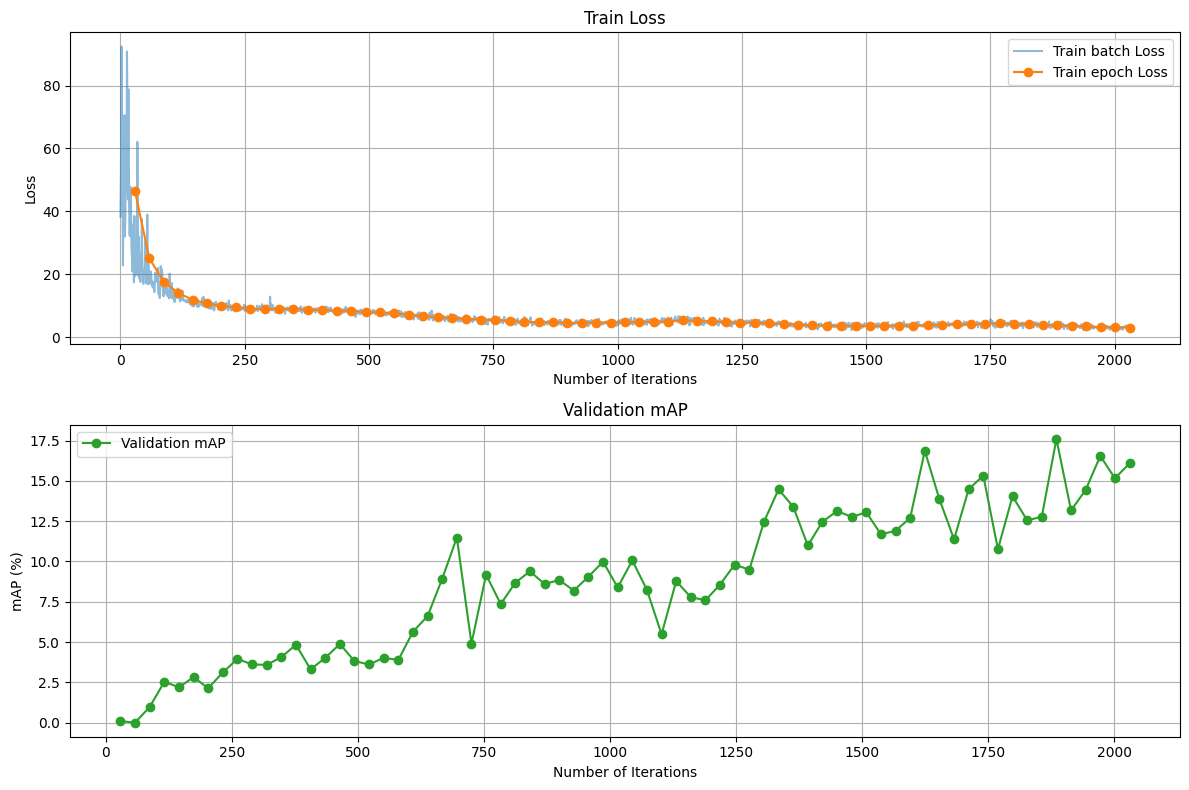

In [120]:
runner.plot_loss(row_figsize=4)

In [125]:
final_map = runner.validate(dataloader=val_loader)
print(f"Final Test mAP: {final_map:.4f}")

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Final Test mAP: 0.1668


Image 1: Found 6 predictions after filtering (score > 0.1).
Image 2: Found 4 predictions after filtering (score > 0.1).
Image 3: Found 0 predictions after filtering (score > 0.1).
Image 4: Found 3 predictions after filtering (score > 0.1).
Image 5: Found 4 predictions after filtering (score > 0.1).


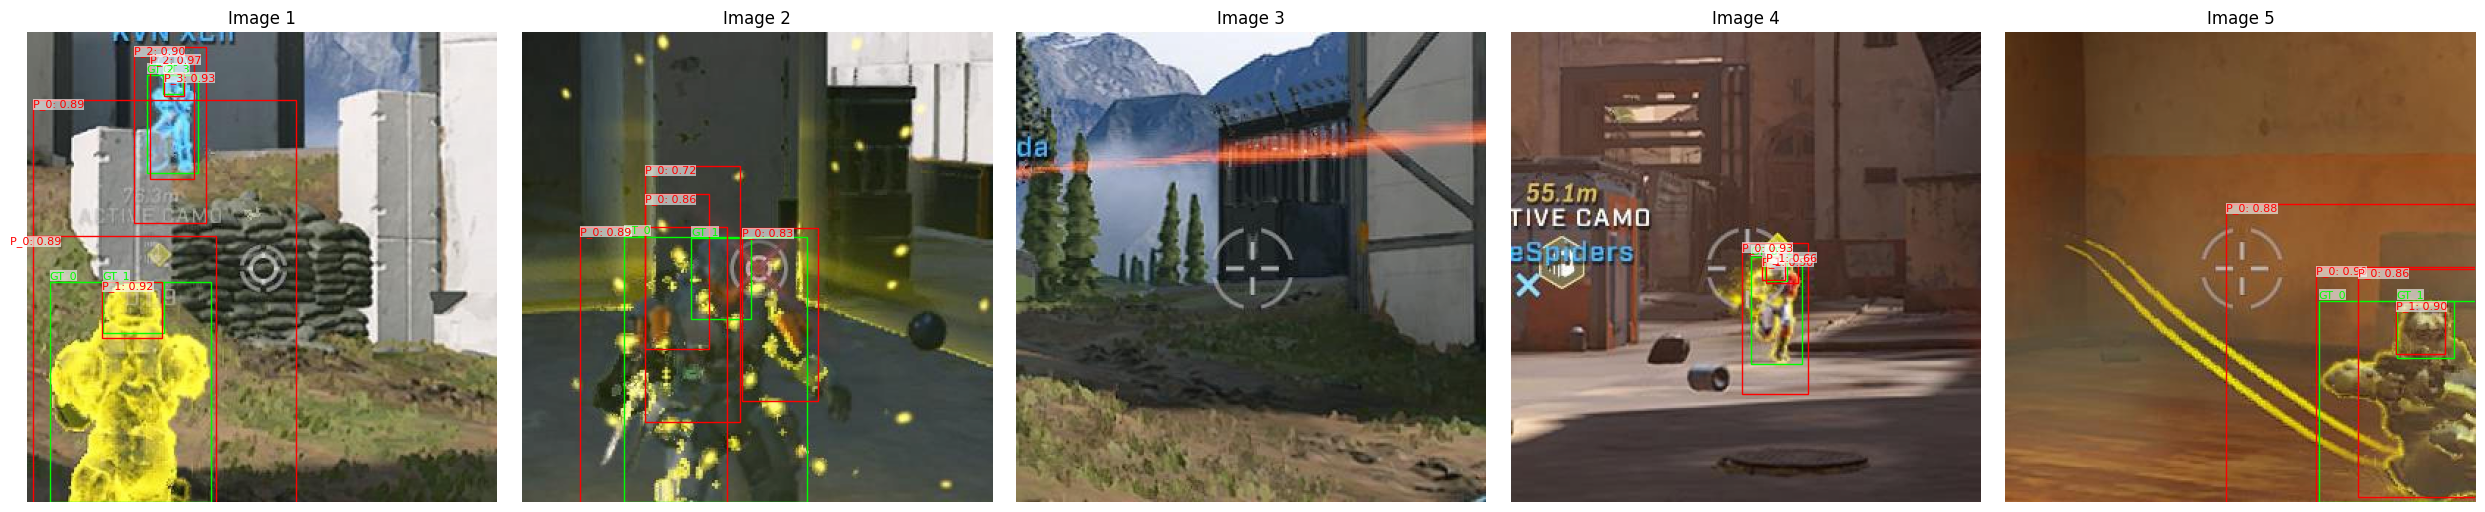

In [126]:
import matplotlib.patches as patches
import random

# Предполагаем, что классы Runner, _filter_predictions и другие необходимые
# компоненты (mean, std, IMAGE_SIZE) определены выше, как в предыдущих ответах.
# Убедитесь, что runner.model, test_loader и runner.device существуют и корректны.

def visualize_predictions_inline(model, dataloader, device, num_images=5, score_threshold=0.1, nms_threshold=0.5, filter_func=None, fig_width_per_image=4, fig_height=4):
    """
    Визуализирует предсказания модели и ground truth для нескольких изображений в одну строку.

    Args:
        model: Обученная модель детекции.
        dataloader: Даталоадер с данными для визуализации.
        device: Устройство ('cuda' или 'cpu').
        num_images: Количество изображений для визуализации.
        score_threshold: Порог уверенности для фильтрации предсказаний.
        nms_threshold: Порог IoU для Non-Maximum Suppression.
        filter_func: Функция для фильтрации предсказаний (если отличается от _filter_predictions).
        fig_width_per_image: Ширина подграфика для одного изображения.
        fig_height: Высота фигуры.
    """
    model.eval()
    # Если filter_func не передан, используем функцию по умолчанию (предполагаем, что она определена)
    filter_predictions_func = _filter_predictions if filter_func is None else filter_func
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    data_iter = iter(dataloader)
    images_shown = 0

    # Создаем фигуру с нужным количеством подграфиков в ряд
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * fig_width_per_image, fig_height))
    # Убедимся, что axes всегда является массивом, даже если num_images=1
    if num_images == 1:
        axes = [axes]

    while images_shown < num_images:
        try:
            images, targets = next(data_iter)
            # Берем по одному изображению из батча, пока не наберем num_images
            for i in range(len(images)):
                if images_shown >= num_images:
                    break

                image_single = images[i:i+1].to(device) # Оставляем размерность батча [1, C, H, W]
                target_single = [targets[i]] # Цель для одного изображения

                with torch.no_grad():
                    (cls_preds_levels, reg_preds_levels, obj_preds_levels), anchors_levels_xyxy = model(image_single)
                    # Декодируем предсказания для одного изображения (вернет список с одним элементом)
                    pred_bboxes_batch, pred_obj_scores_batch, pred_cls_scores_batch = runner._decode_predictions(
                        [lvl[0:1] for lvl in reg_preds_levels], # Берем срез для одного изображения
                        [lvl[0:1] for lvl in obj_preds_levels],
                        [lvl[0:1] for lvl in cls_preds_levels],
                        anchors_levels_xyxy
                    )
                    # Фильтруем предсказания для одного изображения (вернет список с одним элементом)
                    final_preds = filter_predictions_func(
                        pred_bboxes_batch, pred_obj_scores_batch, pred_cls_scores_batch,
                        num_classes=model.num_classes,
                        score_threshold=score_threshold,
                        nms_threshold=nms_threshold,
                        max_boxes_per_cls=100,
                        return_type="torch" # Оставляем тензоры на device
                    )

                # Получаем данные для текущего изображения
                img_tensor = image_single[0].cpu() # Берем тензор изображения [C, H, W]
                pred_data = final_preds[0] # Берем словарь предсказаний для этого изображения
                gt_data = target_single[0] # Берем словарь таргетов для этого изображения

                # Денормализация
                img_np = img_tensor.permute(1, 2, 0).numpy()
                img_np = np.clip((img_np * std + mean), 0, 1) # Clip чтобы избежать артефактов

                # Выбираем текущий subplot
                ax = axes[images_shown]
                ax.imshow(img_np)
                ax.set_title(f"Image {images_shown+1}")
                ax.axis('off')

                # Отображаем Ground Truth
                gt_boxes = gt_data['boxes']
                gt_labels = gt_data['labels']
                for box, label in zip(gt_boxes, gt_labels):
                    # Переводим на CPU если GT на GPU
                    box_cpu = box.cpu().tolist()
                    label_cpu = label.cpu().item()
                    x1, y1, x2, y2 = box_cpu
                    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='lime', facecolor='none') # Зеленый для GT
                    ax.add_patch(rect)
                    ax.text(x1, y1 - 5, f'GT_{label_cpu}', color='lime', fontsize=8, bbox=dict(facecolor='white', alpha=0.6, pad=0, edgecolor='none'))

                # Отображаем предсказания
                boxes = pred_data['boxes'].cpu()
                labels = pred_data['labels'].cpu()
                scores = pred_data['scores'].cpu()

                print(f"Image {images_shown+1}: Found {len(boxes)} predictions after filtering (score > {score_threshold}).")

                for box, label, score in zip(boxes, labels, scores):
                    x1, y1, x2, y2 = box.tolist()
                    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='red', facecolor='none') # Красный для предсказаний
                    ax.add_patch(rect)
                    ax.text(x1, y1 + 10, f'P_{label.item()}: {score:.2f}', color='red', fontsize=8, bbox=dict(facecolor='white', alpha=0.6, pad=0, edgecolor='none'))

                images_shown += 1

        except StopIteration:
            print(f"Dataloader ended after showing {images_shown} images.")
            # Если изображений в даталоадере меньше, чем num_images, отключаем лишние оси
            for k in range(images_shown, num_images):
                 axes[k].axis('off')
            break
        except Exception as e:
            print(f"Error during visualization loop: {e}")
            import traceback
            traceback.print_exc() # Печатаем traceback для детальной ошибки
            break

    plt.tight_layout() # Подгоняем расположение графиков
    plt.show()
    model.train() # Возвращаем модель в режим обучения

visualize_predictions_inline(
    runner.model,
    test_loader,
    runner.device,
    num_images=5, # Показываем 5 изображений
    score_threshold=0.1, # Используем более реалистичный порог
    nms_threshold=0.45, # Используем чуть более строгий NMS
    filter_func=runner.filter_predictions_func, # Передаем функцию фильтрации из runner
    fig_width_per_image=5, # Ширина каждого подграфика
    fig_height=5 # Высота всей строки
)